# VEM Noteboook

This notebook showcases some of the functionality of the program.

In [21]:
#=
using Pkg
Pkg.add("Mat")
Pkg.add("Plots")
Pkg.add("Colors")
=#


In [1]:
using Plots
using SparseArrays
using LinearAlgebra
using MAT

# using GeoDataFrames
# using DataFrames
# using GeometryBasics 

# local modules
push!(LOAD_PATH, realpath("."))
using vem_problem
using plot_solution
using read_mat
using vem_method

## Entering Data Into Mesh

Uses `vem_problem` module and `Mesh` struct.

In [2]:
# Example mesh data
vertices = [(0.0, 0.0), (1.5, 0.0), (1.2, 1.0), (0.0, 1.0), (0.7, 0.4)]
elements = [[1, 2, 5], [2, 3, 5], [3, 4, 5], [4, 1, 5]]
boundary = [1, 2, 3, 4]

#values = [0.1, 0.5, 0.7, 0.9]  # Values assigned to each element

# Create the mesh
mesh_data = Mesh(boundary, elements, vertices)

println("Boundary Nodes: ", mesh_data.boundary)
println("Element Nodes: ", mesh_data.elements)
println("Node Coordinates: ", mesh_data.vertices)

Boundary Nodes: [1, 2, 3, 4]
Element Nodes: [[1, 2, 5], [2, 3, 5], [3, 4, 5], [4, 1, 5]]
Node Coordinates: [(0.0, 0.0), (1.5, 0.0), (1.2, 1.0), (0.0, 1.0), (0.7, 0.4)]


# Read .mat files into struct

Uses `read_mat` module.

In [3]:
filepath = "/Users/roryyarr/Desktop/UON/Summer project 2023-2024/NA45/vem_50lines/meshes/voronoi.mat"

mat_data = read_mat_to_vem_problem(filepath)

println("Boundary Nodes: ", mat_data.boundary)
println("Element Nodes: ", mat_data.elements)
println("Node Coordinates: ", mat_data.vertices)

Boundary Nodes: [1, 2, 3, 4, 10, 14, 15, 18, 19, 20, 24, 25, 69, 80, 82, 83, 107, 108, 109, 133, 134, 138, 139, 140, 171, 174, 175, 183, 186, 189, 191, 199, 200, 201, 204, 206, 208, 209, 210, 211, 217, 218, 228, 229, 240, 250, 268, 270, 271, 272, 273, 274, 275, 276, 318, 321, 322, 324, 326, 327, 329, 335, 336, 337, 340, 361, 364, 387, 389, 390, 392, 393, 396, 397, 400, 403, 413, 417, 418, 427, 428, 454, 455, 456, 457, 458, 465, 466, 467, 472, 473, 474, 495, 499, 500, 524, 525, 526, 532, 533, 535, 538, 558, 559, 564, 604, 605, 610, 611, 637, 638, 670, 671, 694, 711, 713, 714, 718, 719, 720, 737, 738, 739, 740, 741, 742, 744, 745, 746, 747, 750, 761, 763, 776, 777, 785, 786, 822, 824, 828, 829, 834, 835, 849, 851]
Element Nodes: [[293, 294, 292, 517, 514, 291], [32, 35, 522, 521, 113, 34], [278, 508, 695, 697, 304], [868, 602, 603, 817, 816, 869], [435, 429, 430, 432, 431, 434], [687, 689, 688, 685, 684, 686], [437, 433, 79, 81, 78, 77], [298, 309, 308, 135, 297], [848, 850, 851, 849], [

# Square domain

## Main Method

<details>
	<summary> Oliver sutens original code </summary>

```matlab

mesh = load(mesh_filepath); % Load the mesh from a .mat file
n_dofs = size(mesh.vertices, 1); n_polys = 3; % Method has 1 degree of freedom per vertex
K = sparse(n_dofs, n_dofs); % Stiffness matrix
F = zeros(n_dofs, 1); % Forcing vector
u = zeros(n_dofs, 1); % Degrees of freedom of the virtual element solution
linear_polynomials = {[0,0], [1,0], [0,1]}; % Impose an ordering on the linear polynomials
mod_wrap = @(x, a) mod(x-1, a) + 1; % A utility function for wrapping around a vector
for el_id = 1:length(mesh.elements)
	vert_ids = mesh.elements{el_id}; % Global IDs of the vertices of this element
	verts = mesh.vertices(vert_ids, :); % Coordinates of the vertices of this element
	n_sides = length(vert_ids); % Start computing the geometric information
	area_components = verts(:,1) .* verts([2:end,1],2) - verts([2:end,1],1) .* verts(:,2);
	area = 0.5 * abs(sum(area_components));
	centroid = sum((verts + verts([2:end,1],:)) .* repmat(area_components,1,2)) / (6*area);
	diameter = 0; % Compute the diameter by looking at every pair of vertices
	for i = 1:(n_sides-1)
		for j = (i+1):n_sides
			diameter = max(diameter, norm(verts(i, :) - verts(j, :)));
		end
	end
	D = zeros(n_sides, n_polys); D(:, 1) = 1;
	B = zeros(n_polys, n_sides); B(1, :) = 1/n_sides;
	for vertex_id = 1:n_sides
		vert = verts(vertex_id, :); % This vertex and its neighbours
		prev = verts(mod_wrap(vertex_id - 1, n_sides), :);
		next = verts(mod_wrap(vertex_id + 1, n_sides), :);
		vertex_normal = [next(2) - prev(2), prev(1) - next(1)]; % Average of edge normals
		for poly_id = 2:n_polys % Only need to loop over non-constant polynomials
			poly_degree = linear_polynomials{poly_id};
			monomial_grad = poly_degree / diameter; % Gradient of a linear is constant
			D(vertex_id, poly_id) = dot(vert - centroid, poly_degree) / diameter;
			B(poly_id, vertex_id) = 0.5 * dot(monomial_grad, vertex_normal);
		end
	end
	projector = (B*D) \ B; % Compute the local Ritz projector to polynomials
	stabilising_term = (eye(n_sides) - D * projector)' * (eye(n_sides) - D * projector);
	G = B*D; G(1, :) = 0;
	local_stiffness = projector' * G * projector + stabilising_term;
	K(vert_ids,vert_ids) = K(vert_ids,vert_ids) + local_stiffness; % Copy local to global
	F(vert_ids) = F(vert_ids) + rhs(centroid) * area / n_sides;
end
boundary_vals = boundary_condition(mesh.vertices(mesh.boundary, :));
internal_dofs = ~ismember(1:n_dofs, mesh.boundary); % Vertices which aren't on the boundary
F = F - K(:, mesh.boundary) * boundary_vals; % Apply the boundary condition
u(internal_dofs) = K(internal_dofs, internal_dofs) \ F(internal_dofs); % Solve
u(mesh.boundary) = boundary_vals; % Set the boundary values
plot_solution(mesh, u)
end

```

</details>

<details>
    <summary> Mermaid diagram of matlab code </summary>

```mermaid
graph TD
    A[Start] --> B[Load mesh from .mat file]
    B --> C[Initialize K, F, u]
    C --> D[Define linear polynomials]
    D --> D1{Loop over mesh elements}
    
    D1 --> D2[Get vert_ids, vertices and n_sides for each element]
    D2 --> D3[Calculate geometric properties: area, centroid]
    D3 --> D3a{Loop over sides}
    D3a --> D3b[Calculate diameter]
    D3b --> D3
    D3 --> D4[Initialize D and B]

    D4 --> D4a{Loop over vertices}
    D4a --> D4b[Calculate vertex normal]
    D4b --> D4b1{Loop over polynomial basis}
    D4b1 --> D4b2[Calculate gradient]
    D4b2 --> D4b3[Update D and B matrices]
    D4b3 --> D4a

    D4a --> D5[Compute local Ritz projector]
    D5 --> D6[Compute stabilizing term]
    D6 --> D7[Compute G matrix]
    D7 --> D8[Assemble local stiffness matrix]
    D8 --> D9[Update K and F matrices]
    D9 --> D1

    D1 --> |All elements processed?| E[Calculate boundary values]
    E --> F[Calculate internal DOFs]
    F --> G[Calculate local stiffness term]
    G --> H[Update K and F]
    H --> I[Solve for u]
    I --> J[End]
```

</details>

### Working section

<details>
    <summary><h3>Current VEM code</h3></summary>

```julia
function vem(mesh::Mesh, rhs::Function, boundary_condition::Function; debug::Bool=false, debug_file_path::String="vem_debug_output.md")::Vector{Float64}
    # Initialize problem dimensions
    n_dofs = length(mesh.vertices)  # Number of degrees of freedom, one per vertex
    n_polys = 3  # Number of polynomials in the VEM space (constant + linear terms)

    # Initialize global stiffness matrix, forcing vector, and solution vector
    K = spzeros(Float64, n_dofs, n_dofs)  # Global stiffness matrix
    F = zeros(n_dofs)  # Global forcing vector
    u = zeros(n_dofs)  # Solution vector (degrees of freedom)

    # Linear polynomials (constant, x, y)
    linear_polynomials = [[0, 0], [1, 0], [0, 1]]  # Polynomial basis functions

    # Debugging: open a debug file if enabled
    if debug
        debug_file = open(debug_file_path, "w")
    end

    # Write the table of contents (TOC) for the debug file if debugging is enabled
    if debug
        write(debug_file, "# Debug Output for VEM Method\n\n")
        write(debug_file, "## Table of Contents\n\n")
        write(debug_file, "- [Number of DOFs](#number-of-dofs)\n")
        write(debug_file, "- [Initial Stiffness Matrix (K)](#initial-stiffness-matrix)\n")
        write(debug_file, "- [Initial Forcing Vector (F)](#initial-forcing-vector)\n")

        # Generate TOC dynamically for each element in the mesh
        for el_id in 1:length(mesh.elements)
            write(debug_file, "- [Element $el_id Details](#element-$el_id-details)\n")
            write(debug_file, "  - [Area, Centroid, Diameter](#element-$el_id-area-centroid-diameter)\n")
            write(debug_file, "  - [D and B Matrices](#element-$el_id-d-and-b-matrices)\n")
            write(debug_file, "  - [K and F Matrices](#element-$el_id-k-and-f-matrices)\n")
        end
        write(debug_file, "- [Boundary Conditions](#boundary-conditions)\n")
        write(debug_file, "- [Final Solution (u)](#final-solution)\n\n")
    end

    # Debugging: initial values of K, F, and u
    if debug
        write(debug_file, "[Back to top](#table-of-contents)\n\n")
        write(debug_file, "## Number of DOFs\nNumber of DOFs: $n_dofs\n\n")
        write(debug_file, "## Initial Stiffness Matrix\nInitial K: $K\n\n")
        write(debug_file, "## Initial Forcing Vector\nInitial F: $F\n\n")
        write(debug_file, "## Initial Degrees of Freedom (u)\nInitial u: $u\n\n")
    end

    # Loop over all elements in the mesh to compute local contributions to K and F
    for el_id in 1:length(mesh.elements)
        vert_ids = mesh.elements[el_id]  # Global vertex IDs of this element
        verts = [mesh.vertices[v] for v in vert_ids]  # Coordinates of the element's vertices
        n_sides = length(vert_ids)  # Number of sides of the polygon (element)

        # Debugging: print element details
        if debug
            write(debug_file, "[Back to top](#table-of-contents)\n\n")
            write(debug_file, "## Element $el_id Details\n")
            write(debug_file, "- Vertex IDs: $vert_ids\n")
            write(debug_file, "- Vertices: $verts\n")
            write(debug_file, "- Number of sides: $n_sides\n\n")
        end

        # Compute geometric properties of the element (area, centroid, and diameter)
        verts_array = hcat([collect(v) for v in verts]...)'  # Convert vertex coordinates to matrix form
        area_components = verts_array[:,1] .* verts_array[[2:end; 1],2] .- verts_array[[2:end; 1],1] .* verts_array[:,2]
        area = 0.5 * abs(sum(area_components))  # Compute the area of the polygon

        # Debugging: print geometric details
        if debug
            write(debug_file, "[Back to top](#table-of-contents)\n\n")
            write(debug_file, "### Element $el_id Area, Centroid, and Diameter\n")
            write(debug_file, "- Area components: $area_components\n")
            write(debug_file, "- Area: $area\n")
        end

        # Compute the centroid of the polygon
        centroid = sum((verts_array .+ verts_array[[2:end; 1],:]) .* repeat(area_components, 1, 2), dims=1) / (6 * area)

        # Compute the diameter of the polygon (largest distance between two vertices)
        diameter = 0.0
        for i in 1:(n_sides-1)
            for j in (i+1):n_sides
                diameter = max(diameter, norm(verts_array[i, :] - verts_array[j, :]))
            end
        end

        # Debugging: print centroid and diameter details
        if debug
            write(debug_file, "- Centroid: $centroid\n")
            write(debug_file, "- Diameter: $diameter\n\n")
        end

        # Initialize D and B matrices for the element
        D = zeros(n_sides, n_polys)  # Matrix D for polynomial projections
        D[:, 1] .= 1  # Constant term in polynomial
        B = zeros(n_polys, n_sides)  # Matrix B for polynomial evaluation
        B[1, :] .= 1 / n_sides  # Constant term for all sides

        # Debugging: print initial D and B matrices
        if debug
            write(debug_file, "[Back to top](#table-of-contents)\n\n")
            write(debug_file, "### Element $el_id D and B Matrices\n")
            write(debug_file, "- D Matrix: $D\n")
            write(debug_file, "- B Matrix: $B\n")
        end

        # Fill the D and B matrices with values for each vertex of the element
        for vertex_id in 1:n_sides
            vert = verts[vertex_id]
            prev = verts[mod(vertex_id - 2, n_sides) + 1]  # Previous vertex
            next = verts[mod(vertex_id, n_sides) + 1]  # Next vertex

            # Coordinates of current, previous, and next vertices
            vert_x, vert_y = vert
            prev_x, prev_y = prev
            next_x, next_y = next

            vertex_normal = [next_y - prev_y, prev_x - next_x]  # Normal vector to the edge
            centroid_vec = vec(centroid)  # Centroid vector

            # Fill D and B for higher-degree polynomials (linear terms)
            for poly_id in 2:n_polys
                poly_degree = linear_polynomials[poly_id]  # Polynomial degrees
                monomial_grad = poly_degree / diameter  # Gradient of the monomial

                D[vertex_id, poly_id] = dot([vert_x, vert_y] .- centroid_vec, poly_degree) / diameter
                B[poly_id, vertex_id] = 0.5 * dot(monomial_grad, vertex_normal)
            end
        end

        # Compute the projector and stabilizing term for the stiffness matrix
        projector = (B * D) \ B  # Projector matrix
        stabilising_term = (I - D * projector)' * (I - D * projector)  # Stabilizing term for the stiffness matrix

        # G matrix for additional stability
        G = B * D
        G[1, :] .= 0  # Set the first row to 0 (to satisfy certain stability conditions)

        # Compute the local stiffness matrix for this element
        local_stiffness = projector' * G * projector + stabilising_term

        # Debugging: print projector, G matrix, and local stiffness matrix
        if debug
            write(debug_file, "[Back to top](#table-of-contents)\n\n")
            write(debug_file, "- Projector: $projector\n")
            write(debug_file, "- Stabilising Term: $stabilising_term\n")
            write(debug_file, "- G Matrix: $G\n")
            write(debug_file, "- Local Stiffness: $local_stiffness\n\n")
        end

        # Assemble the local stiffness matrix into the global matrix K
        for i in 1:length(vert_ids)
            for j in 1:length(vert_ids)
                K[vert_ids[i], vert_ids[j]] += local_stiffness[i, j]
            end
        end

        # Compute the contribution to the global forcing vector F
        rhs_value = rhs(centroid)  # Evaluate the right-hand side function at the centroid
        F[vert_ids] .+= rhs_value * area / n_sides

        # Debugging: print element contribution to K and F
        if debug
            write(debug_file, "[Back to top](#table-of-contents)\n\n")
            write(debug_file, "### Element $el_id K and F Matrices\n")
            write(debug_file, "- RHS value: $rhs_value\n")
            write(debug_file, "- Updated K and F Matrices\n\n")
        end
    end

    # Apply boundary conditions
    boundary_values = boundary_condition(mesh.vertices)
    if debug
        write(debug_file, "[Back to top](#table-of-contents)\n\n")
        write(debug_file, "## Boundary Conditions\n")
        write(debug_file, "- Boundary Values: $boundary_values\n\n")
    end

    for idx in mesh.boundary
        u[idx] = boundary_values[idx]  # Set solution values at boundary
        K[idx, :] .= 0  # Zero out the row in K
        K[idx, idx] = 1.0  # Set the diagonal entry to 1
        F[idx] = boundary_values[idx]  # Set the corresponding entry in F
    end

    # Solve the system K * u = F to find the solution
    u = K \ F

    # Debugging: print the final solution
    if debug
        write(debug_file, "[Back to top](#table-of-contents)\n\n")
        write(debug_file, "## Final Solution\n")
        write(debug_file, "- Final Solution u: $u\n")
    end

    # Close the debug file if it was opened
    if debug
        close(debug_file)
    end

    return u  # Return the computed solution
end
```

</details>


In [10]:
function square_domain_rhs(points::Vector{Tuple{Float64, Float64}})::Float64
    # Extract x and y coordinates from the points vector of tuples
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    
    # Standard multiplication (not element-wise) similar to MATLAB behavior
    f = 15 * sin(π * sum(x)) * sin(π * sum(y))
    
    return f
end


square_domain_rhs (generic function with 1 method)

In [4]:
function square_domain_rhs(points::Matrix{Float64})::Float64
    # Extract x and y coordinates from the points matrix
    x = points[:, 1]
    y = points[:, 2]
    
    # Standard multiplication (not element-wise) similar to MATLAB behavior
    f = 15 * sin(π * sum(x)) * sin(π * sum(y))
    
    return f
end

square_domain_rhs (generic function with 1 method)

In [13]:
test_point_julia = [(0.5, 0.5)]
result_julia = square_domain_rhs(test_point_julia)
result_julia

15.0

In [5]:
function square_domain_boundary_condition(points::Vector{Tuple{Float64, Float64}})::Vector{Float64}
    # Extract x and y coordinates from the points vector of tuples
    x = [p[1] for p in points]
    y = [p[2] for p in points]
    
    # Element-wise multiplication and sine function
    g = (1 .- x) .* y .* sin.(π .* x)
    
    return g
end


square_domain_boundary_condition (generic function with 1 method)

In [6]:
# Create the Mesh struct
#mesh = Mesh(boundary, elements, vertices)
filepath = "/Users/roryyarr/Desktop/UON/Summer project 2023-2024/NA45/vem_50lines/meshes/L-domain.mat"

mat_data = read_mat_to_vem_problem(filepath)


# Call the VEM method
u = vem(mat_data, square_domain_rhs, square_domain_boundary_condition, debug = true)

# Display or work with the solution `u`
println("Solution: ", u)

Solution: [2.5531215205351146e-11, 4.5524891426434354e-11, -2.217314696587644e-19, -1.8746133618519927e-19, -4.924677713734934e-11, 1.2211807058660035e-10, 9.986921507872965e-11, 7.959214933766435e-11, 1.1840474551329117, -4.3808486058890445e-19, -0.7587714704379597, -0.42777486578613216, -0.2482089205699983, -0.8117295293502552, -0.6687048253488886, -0.6620858531507733, -0.07499379308876122, -3.55923634361018e-19, -2.2254001222674626e-19, -3.230632563644217e-19, -1.620519288233493e-19, -0.4477442334703154, -0.2998490330282214, -3.327136106945322e-11, -3.2792447195679967e-11, 0.23601715273665913, -0.027418677099505767, 0.6465360185231503, 0.9687214499425917, -1.205024739878192e-10, -5.569303502532537e-11, -1.0192235391093998e-10, -7.365877713559576e-11, 0.4210878827409954, 0.6907567370939288, 1.196252939249647, 1.2776060445282507, -0.045577545965066066, 1.1840474551309355, 0.6210738472008371, -0.6330515318018737, -0.6524951076881856, 0.29251589470501643, -0.04557754596185026, 0.0540395

<details>
    <summary><h2> Matlab debuger </h2></summary>

```matlab
function vem_debug(mesh_filepath, rhs, boundary_condition, debug_filepath)
    % Load the mesh from a .mat file
    mesh = load(mesh_filepath);
    n_dofs = size(mesh.vertices, 1); 
    n_polys = 3;  % Method has 1 degree of freedom per vertex

    K = sparse(n_dofs, n_dofs);  % Stiffness matrix
    F = zeros(n_dofs, 1);        % Forcing vector
    u = zeros(n_dofs, 1);        % Degrees of freedom of the virtual element solution
    linear_polynomials = {[0, 0], [1, 0], [0, 1]};  % Linear polynomials

    % Open the debug file for writing
    fid = fopen(debug_filepath, 'w');

    % Write the table of contents (TOC)
    fprintf(fid, '# Debug Output for VEM Method\n\n');
    fprintf(fid, '## Table of Contents\n\n');
    fprintf(fid, '- [Number of DOFs](#number-of-dofs)\n');
    fprintf(fid, '- [Initial Stiffness Matrix (K)](#initial-stiffness-matrix)\n');
    fprintf(fid, '- [Initial Forcing Vector (F)](#initial-forcing-vector)\n');
    fprintf(fid, '- [Element Details](#element-details)\n');
    fprintf(fid, '  - [Area, Centroid, Diameter](#area-centroid-and-diameter)\n');
    fprintf(fid, '  - [D and B Matrices](#d-and-b-matrices)\n');
    fprintf(fid, '  - [Projector and Stiffness Calculation](#projector-and-stiffness-calculation)\n');
    fprintf(fid, '- [Boundary Conditions](#boundary-conditions)\n');
    fprintf(fid, '- [Final Solution (u)](#final-solution)\n\n');

    % Initialize element-specific TOC
    element_toc = '';

    % Number of DOFs
    fprintf(fid, '[Back to top](#table-of-contents)\n\n');
    fprintf(fid, '## Number of DOFs\n');
    fprintf(fid, 'Number of DOFs: %d\n\n', n_dofs);

    % Initial Stiffness Matrix and Forcing Vector
    fprintf(fid, '[Back to top](#table-of-contents)\n\n');
    fprintf(fid, '## Initial Stiffness Matrix\n');
    fprintf(fid, 'Initial K: (empty sparse matrix)\n\n');

    fprintf(fid, '[Back to top](#table-of-contents)\n\n');
    fprintf(fid, '## Initial Forcing Vector\n');
    fprintf(fid, 'Initial F: (zero vector)\n\n');

    % Iterate over each element in the mesh
    for el_id = 1:length(mesh.elements)
        vert_ids = mesh.elements{el_id};  % Global IDs of the vertices of this element
        verts = mesh.vertices(vert_ids, :);  % Coordinates of the vertices of this element
        n_sides = length(vert_ids);  % Number of sides of the polygon

        % Append element link to the table of contents
        element_toc = strcat(element_toc, sprintf('  - [Element %d](#element-%d)\n', el_id, el_id));

        % Write element-specific debug information
        fprintf(fid, '[Back to top](#table-of-contents)\n\n');
        fprintf(fid, '## Element Details\n\n');
        fprintf(fid, '### Element ID: %d {#element-%d}\n', el_id, el_id);
        fprintf(fid, '- Vertex IDs: %s\n', mat2str(vert_ids));
        fprintf(fid, '- Vertices: %s\n', mat2str(verts));
        fprintf(fid, '- Number of sides: %d\n\n', n_sides);

        % Compute geometric information
        area_components = verts(:,1) .* verts([2:end,1],2) - verts([2:end,1],1) .* verts(:,2);
        area = 0.5 * abs(sum(area_components));
        centroid = sum((verts + verts([2:end,1],:)) .* repmat(area_components, 1, 2)) / (6 * area);
        diameter = 0;
        for i = 1:(n_sides-1)
            for j = (i+1):n_sides
                diameter = max(diameter, norm(verts(i, :) - verts(j, :)));
            end
        end

        fprintf(fid, '[Back to top](#table-of-contents)\n\n');
        fprintf(fid, '### Area, Centroid, and Diameter\n');
        fprintf(fid, '- Vertices array: %s\n', mat2str(verts));
        fprintf(fid, '- Area components: %s\n', mat2str(area_components));
        fprintf(fid, '- Area: %f\n', area);
        fprintf(fid, '- Centroid: [%f, %f]\n', centroid(1), centroid(2));
        fprintf(fid, '- Diameter: %f\n\n', diameter);

        % Initialize D and B matrices
        D = zeros(n_sides, n_polys); 
        D(:, 1) = 1;
        B = zeros(n_polys, n_sides); 
        B(1, :) = 1 / n_sides;

        % Write D and B matrices information
        fprintf(fid, '[Back to top](#table-of-contents)\n\n');
        fprintf(fid, '### D and B Matrices\n');

        for vertex_id = 1:n_sides
            vert = verts(vertex_id, :);  % This vertex and its neighbours
            prev = verts(mod(vertex_id - 2, n_sides) + 1, :);
            next = verts(mod(vertex_id, n_sides) + 1, :);
            vertex_normal = [next(2) - prev(2), prev(1) - next(1)];  % Average of edge normals

            for poly_id = 2:n_polys
                poly_degree = linear_polynomials{poly_id};
                monomial_grad = poly_degree / diameter;  % Gradient of a linear is constant
                D(vertex_id, poly_id) = dot(vert - centroid, poly_degree) / diameter;
                B(poly_id, vertex_id) = 0.5 * dot(monomial_grad, vertex_normal);
            end
        end

        fprintf(fid, '- D Matrix: %s\n', mat2str(D));
        fprintf(fid, '- B Matrix: %s\n\n', mat2str(B));

        % Compute the local Ritz projector and stabilising term
        projector = (B * D) \ B;
        stabilising_term = (eye(n_sides) - D * projector)' * (eye(n_sides) - D * projector);
        G = B * D;
        G(1, :) = 0;
        local_stiffness = projector' * G * projector + stabilising_term;

        fprintf(fid, '[Back to top](#table-of-contents)\n\n');
        fprintf(fid, '### Projector and Stiffness Calculation\n');
        fprintf(fid, '- Projector: %s\n', mat2str(projector));
        fprintf(fid, '- Stabilising Term: %s\n', mat2str(stabilising_term));
        fprintf(fid, '- Local Stiffness: %s\n\n', mat2str(local_stiffness));

        % Assemble global stiffness matrix and forcing vector
        K(vert_ids, vert_ids) = K(vert_ids, vert_ids) + local_stiffness;
        F(vert_ids) = F(vert_ids) + rhs(centroid) * area / n_sides;
    end

    % Append the element-specific TOC at the end of the general TOC
    fprintf(fid, element_toc);

    % Apply boundary conditions
    boundary_vals = boundary_condition(mesh.vertices(mesh.boundary, :));
    internal_dofs = ~ismember(1:n_dofs, mesh.boundary);
    F = F - K(:, mesh.boundary) * boundary_vals;  % Apply the boundary condition
    u(internal_dofs) = K(internal_dofs, internal_dofs) \ F(internal_dofs);  % Solve
    u(mesh.boundary) = boundary_vals;  % Set the boundary values

    fprintf(fid, '[Back to top](#table-of-contents)\n\n');
    fprintf(fid, '## Boundary Conditions\n');
    fprintf(fid, '- Boundary Values: %s\n\n', mat2str(boundary_vals));

    fprintf(fid, '[Back to top](#table-of-contents)\n\n');
    fprintf(fid, '## Final Solution\n');
    fprintf(fid, '- Final Solution u: %s\n', mat2str(u));

    % Close the debug file
    fclose(fid);
end
```

</details>

In [11]:
# Matlab solution
a = [
    0.0000, 0.0000, -0.0000, -0.0000, -0.0000, 0.0000, 0.0000, 0.0000, 1.1840, -0.0000,
   -0.7588, -0.4278, -0.2482, -0.8117, -0.6687, -0.6621, -0.0750, -0.0000, -0.0000, -0.0000,
   -0.0000, -0.4477, -0.2998, -0.0000, -0.0000, 0.2360, -0.0274, 0.6465, 0.9687, -0.0000,
   -0.0000, -0.0000, -0.0000, 0.4211, 0.6908, 1.1963, 1.2776, -0.0456, 1.1840, 0.6211,
   -0.6331, -0.6525, 0.2925, -0.0456, 0.0540, 0.6211, 0.5890, 0.3358, -0.6747, -0.7819,
   -0.7107, -0.1148, -0.3166, -0.4742, -0.6486, -0.6117, -0.6759, -0.7882, -0.7613, -0.8119,
   -0.3278, -0.5282, -0.0000, -0.0000, 0.4042, 0.4880, 0.0000, 0.0000, 0.0000, -0.4548,
   -0.4135, -0.5065, -1.2396, -1.2396, -0.0000, 0.4063, -0.1035, 0.0000, -0.2421, -0.0000,
    1.1866, 1.1866, 1.5251, 1.5251, 0.5627, 0.8293, 0.3341, 0.4144, 0.5810, 0.7465,
    0.9336, 0.9489, 1.1422, 1.0642, 1.1574, 0.8646, -0.4274, -0.5791, -0.5125, -0.0274,
   -0.2825, -0.2799, -0.5957, -0.5817, -0.3710, -0.5452, -0.0275, -0.1524, 0.1567, 0.0291,
   -0.0922, -0.3485, -0.0712, -0.5578, -0.6567, 0.1898, -0.0000, 0.1739, -0.0003, -0.0000,
    0.8477, 0.4479, 0.1591, 0.1836, 0.4651, 0.6751, 0.6966, -0.5829, -0.5791, -0.3836,
   -0.4274, -0.5086, -0.5086, -0.2927, -0.4193, -0.4786, -0.2927, -0.0750, -0.2122, -0.0000,
   -0.0000, -0.3411, -0.4674, -0.3040, -0.0000, -0.2328, -0.0000, -0.5775, -0.0000, -0.8390,
   -0.4180, -0.2535, -1.1661, -1.1043, -1.0306, -0.6262, -0.7319, 1.0859, 1.0323, 1.1706,
    1.1476, -0.0000, -0.0000, -0.1803, -0.1786, -0.0000, -0.0000, -0.0000, -0.4000, 0.0075,
   -0.1426, 0.2971, 0.0717, 0.1341, -0.2710, -0.0000, -0.0000, -0.0000, -0.0000, -0.5162,
   -0.7962, -0.8390, -1.0958, -1.2462, -1.4862, -1.4862, -0.0000, -0.4384, -0.2640, -0.3032,
    1.0060, 0.6886, 0.8342, 0.9918, -0.5143, -0.4386, -0.7309, -0.7468, -0.6048, -0.0427,
   -0.2554, 0.2260, 0.2056, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0, -0.0000,
   -0.0000, -0.9568, -1.1041, 0.7853, 0.9500, 0.4798, 0.3837, 0.5366, 0.6409, -0.2085,
   -0.3393, -0.2654, -0.0355, -0.0236, -0.0540, -0.7195, -0.6826, -0.7987, -0.9509, -0.7467,
   -0.5155, -0.4935, -0.9686, -0.9919, -1.0559, -1.0870, -0.6753, -0.6780, -0.6041
]


239-element Vector{Float64}:
  0.0
  0.0
 -0.0
 -0.0
 -0.0
  0.0
  0.0
  0.0
  1.184
 -0.0
  ⋮
 -0.5155
 -0.4935
 -0.9686
 -0.9919
 -1.0559
 -1.087
 -0.6753
 -0.678
 -0.6041

# Plot Solution

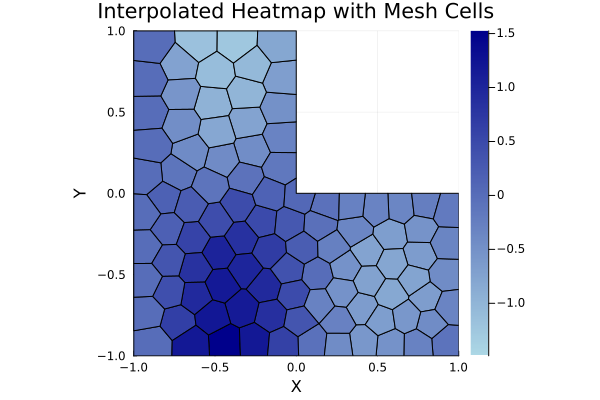

In [7]:
#PlotSolution(mat_data, u)
plot_heatmap(mat_data, u)

In [20]:
tolerance = 1e-4  # Define your tolerance level

# Check if all values are within the tolerance
within_tolerance = all(abs.(a .- u) .< tolerance)

# Output the result
println("All values within tolerance: ", within_tolerance)

All values within tolerance: true


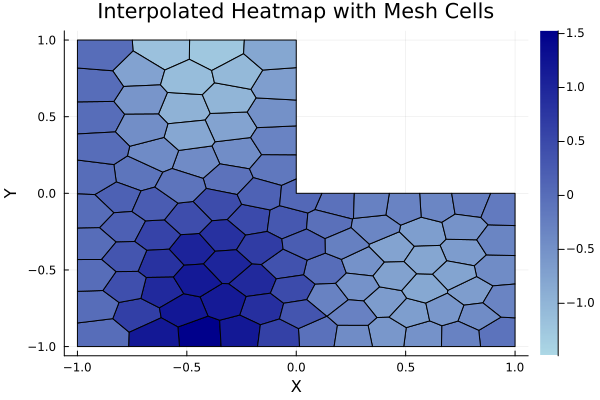

In [51]:
plot_heatmap(mat_data, a)

<details>
    <summary><h3>Heatmap Plot</h3></summary>

```julia
"""
    plot_heatmap(mesh::Mesh, solution::Vector{Float64}; colourscheme=:blues, show_colorbar=true)

Plot an interpolated heatmap over a mesh structure with optional cell boundaries, color scheme, and color bar.

# Arguments
- `mesh::Mesh`: A `Mesh` struct containing the boundary vertices, elements (polygons), and vertex coordinates.
- `solution::Vector{Float64}`: A vector containing the solution values (e.g., temperature, potential) for each vertex.

# Keyword Arguments
- `colourscheme`: A symbol representing the color scheme to use for the heatmap. Default is `:blues`, but can be any valid color scheme (e.g., `:viridis`, `:plasma`).
- `show_colorbar::Bool`: A boolean flag that determines whether the color bar is shown. Default is `true` (color bar shown). Set to `false` to hide the color bar.

# Behavior
- The function will plot the heatmap by interpolating the solution values over the mesh.
- It fills each element (polygon/triangle) in the mesh with interpolated colors, using the specified color scheme.
- The x and y axis limits are automatically set based on the mesh vertices.
- The color bar can be toggled on or off using the `show_colorbar` argument.

# Using the default 'blues' color scheme and showing the color bar
plot_heatmap!(mesh, solution)

# Using the 'plasma' color scheme and hiding the color bar
plot_heatmap!(mesh, solution; colourscheme=:plasma, show_colorbar=false)
"""

# Function to plot the interpolated heatmap with overlaid cell boundaries, equal aspect ratio, automatic axis limits, color scheme option, and optional color bar
function plot_heatmap(mesh::Mesh, solution::Vector{Float64}; colourscheme=:blues, show_colourbar=true)
    # Extract the vertices and solution values
    x_coords = [v[1] for v in mesh.vertices]
    y_coords = [v[2] for v in mesh.vertices]

    # Calculate the axis limits based on the mesh vertices
    x_min, x_max = minimum(x_coords), maximum(x_coords)
    y_min, y_max = minimum(y_coords), maximum(y_coords)

    # Create a plot object with aspect ratio and axis limits, conditionally showing the color bar
    p = plot(legend = false, aspect_ratio = :equal, xlims=(x_min, x_max), ylims=(y_min, y_max), 
             colorbar = show_colourbar ? :right : false)

    # Loop through each element to fill with interpolated color
    for element in mesh.elements
        # Extract the x, y coordinates of the vertices in the element
        x_elem = x_coords[element]
        y_elem = y_coords[element]
        
        # Get the solution values for the vertices of the element
        solution_elem = solution[element]

        # Fill the polygon (triangle/polygon in this case) with interpolated color
        plot!(p, x_elem, y_elem, fill_z = solution_elem, seriestype = :shape, lw = 1, colour=colourscheme)
    end

    # Final plot customization
    xlabel!(p, "X")
    ylabel!(p, "Y")
    title!(p, "Interpolated Heatmap with Mesh Cells")

    # Display the plot
    display(p)
end
```

</details>

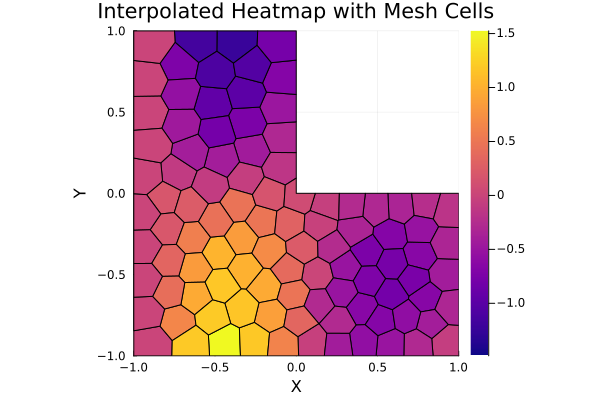

In [8]:
plot_heatmap(mat_data, u, colourscheme=:plasma)

<details>
    <summary><h3> Wireframe Plot </h3></summary>

```julia
"""
    plot_wireframe(mesh::Mesh, heights::Vector{Float64}; azimuth=30, elevation=30, solidcolour=nothing, colourscheme=:viridis)

Plot a 3D wireframe of a mesh with either a solid color or a color scheme based on vertex heights.

# Arguments
- `mesh::Mesh`: A `Mesh` struct containing the boundary vertices, elements (polygons), and vertex coordinates.
- `heights::Vector{Float64}`: A vector containing the heights (z-coordinates) of each vertex.
  
# Keyword Arguments
- `azimuth::Float64`: The azimuth angle (horizontal rotation) for viewing the 3D plot. Default is `30`.
- `elevation::Float64`: The elevation angle (vertical rotation) for viewing the 3D plot. Default is `30`.
- `solidcolour`: A solid color for the wireframe (e.g., `:red`, `:blue`). If provided, it overrides the color scheme.
- `colourscheme`: A color scheme symbol (e.g., `:viridis`, `:plasma`) to color the wireframe based on vertex heights. Default is `:viridis`.

# Behavior
- If `solidcolour` is provided, all wireframe lines will be plotted with this solid color.
- If `colourscheme` is provided and `solidcolour` is `nothing`, the wireframe will be colored based on vertex heights using the color scheme.

# Using a color scheme
plot_wireframe(mesh, heights, azimuth=45, elevation=60, colourscheme=:plasma)

# Using a solid color
plot_wireframe(mesh, heights, azimuth=45, elevation=60, solidcolour=:green)
"""
# Function to plot the wireframe with color based on height and specified viewing angle and color scheme
function plot_wireframe(mesh::Mesh, heights::Vector{Float64}; azimuth=30, elevation=30, solidcolour=nothing, colourscheme=:viridis)
    # Extract vertices coordinates
    x_coords = [v[1] for v in mesh.vertices]
    y_coords = [v[2] for v in mesh.vertices]

    # Normalize heights for color mapping
    min_h = minimum(heights)
    max_h = maximum(heights)
    norm_heights = (heights .- min_h) ./ (max_h - min_h)

    # Initialize 3D plot with camera position
    fig = plot3d(title="Wireframe Mesh (Colored by Height)", legend=false, camera=(azimuth, elevation))

    # Loop through each element and plot the wireframe
    for element in mesh.elements
        # Get the x, y, and z coordinates for the current element
        x_el = [x_coords[i] for i in element]
        y_el = [y_coords[i] for i in element]
        z_el = [heights[i] for i in element]

        # Close the polygon by adding the first vertex at the end
        append!(x_el, x_el[1])
        append!(y_el, y_el[1])
        append!(z_el, z_el[1])

        # Determine color based on provided inputs
        if solidcolour !== nothing
            # Use the solid color if provided
            line_colour = solidcolour
        elseif colourscheme !== nothing
            # Use the color scheme if no solid color is provided
            avg_height = mean(norm_heights[element])  # Average height for the element
            line_colour = cgrad(colourscheme)[round(Int, avg_height * 255) + 1]  # Color from gradient
        else
            error("Please provide either a valid color scheme or a solid color.")
        end

        # Plot the edges of the polygon
        plot3d!(x_el, y_el, z_el, linecolor=line_colour, linewidth=1.5)
    end

    # Show the plot
    display(fig)
end
```

</details>

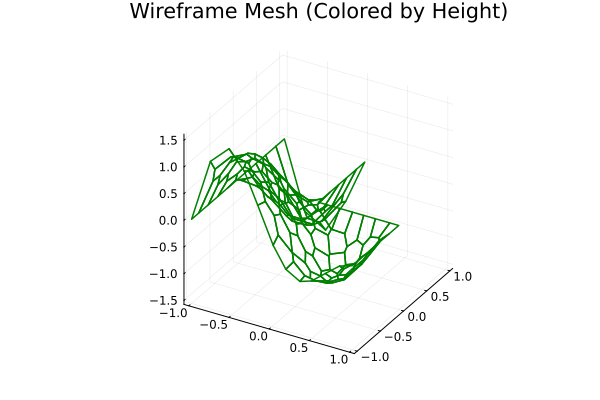

In [9]:
#plot_wireframe(mat_data, u, colourscheme = :plasma)
plot_wireframe(mat_data, u, solidcolour = :green)